In [2]:
using CSV, DataFrames, Distances, Formatting, Plots

In [3]:
cities = CSV.read("cities_p.csv");

In [4]:
mutable struct Score
    value :: Float64
    dist_path :: Vector{Float64}
    scaled_dist_path ::  Vector{Float64}
end

In [5]:
mutable struct Cities
    xy :: Array{Float64,2}
    nprimes :: Vector{Float64}
end

In [6]:
function get_score(cities, subm_path)
    all_ids = cities[:CityId]
    all_x = cities[:X]
    all_y = cities[:Y]

    incs = 0
    score = 0.0
    pimp = 0.0
    for i in 1:length(subm_path)-1
        c_idx = subm_path[i]+1
        n_idx = subm_path[i+1]+1
        p1 = [all_x[c_idx],all_y[c_idx]]
        p2 = [all_x[n_idx],all_y[n_idx]]
        stepSize = euclidean(p1,p2)
        if i % 10 == 0 && !cities[:primes][subm_path[i]+1]
            pimp += 0.1*stepSize
            stepSize *= 1.1
            incs += 1
        end
        # print(stepSize)
        score += stepSize
    end
    return score, incs, pimp
end

get_score (generic function with 1 method)

In [93]:
function calc_score(cities, list_path, tenth)
    @views xy_cities = cities.xy
    len_path     = length(list_path)
    # Calc Distance
    @views xy_path   = xy_cities[list_path,:]
    @views @inbounds dist_path = sqrt.(sum((xy_path[1:end-1,:] .- xy_path[2:end,:]).^2; dims=2))[:,1]
    
    # List of Primes 0 to (len_path-1)
    # Flag array, is path's from-city number non-prime?
    @views is_path_from_non_prime   = cities.nprimes[list_path][1:end-1]   
    # If both flags are true, *1.1, else * 1.0
    extra = dist_path .* 0.1 .* is_path_from_non_prime .* tenth
    return sum(dist_path)+sum(extra), dist_path, extra
end

calc_score (generic function with 1 method)

In [112]:
cities_csv = CSV.read("cities_p.csv");
subm_df = CSV.read("submissions/mip_n272_t400.csv");
subm_path = subm_df[:Path];
@time begin
    test_sp = sort(subm_path)
    @assert test_sp[2:end] == collect(0:197768)
end

tenth = [(i % 10) == 0 for i in 1:length(subm_path)-1]
subm_path .+= 1
xy_cities   = zeros(size(cities_csv)[1],2)
xy_cities[:,1] = cities_csv[:X] 
xy_cities[:,2] = cities_csv[:Y]
cities = Cities(xy_cities, cities_csv[:nprime])
println(length(subm_path))
@time score, normal_dist, extra = calc_score(cities, subm_path, tenth)
println("Normal distance: ", format( sum(normal_dist), commas=true, precision=2))
println("Extra: ", format( sum(extra), commas=true, precision=2))
println("Extra #: ", format( length(extra[extra .> 0.]), commas=true, precision=2))
println("Tenth #: ", format( length(tenth[tenth .== 1]), commas=true, precision=2))
println("Primes #: ", format( length(cities_csv[:nprime][cities_csv[:nprime] .== false]), commas=true, precision=2))
max_5_extra = partialsortperm(extra, 1:5; rev=true)
println("Max 5 extra costs: ", extra[max_5_extra])
println("at indexes: ", max_5_extra)
formatted_score = format( score, commas=true, precision=2)
println("Score: ", formatted_score)
println("Distance to 1: ", score-1514599.52)
println("Distance to Gold: ", score-1515568.17)
println("Distance to current: ", score-1515921.99)
println("Distance to concorde week reversed: ", score-1516737.28)

  0.023365 seconds (13 allocations: 4.904 MiB)
197770
  0.020196 seconds (45 allocations: 12.638 MiB, 22.30% gc time)
Normal distance: 1,503,269.75
Extra: 12,983.41
Extra #: 17,200
Tenth #: 19,776
Primes #: 17,802
Max 5 extra costs: [12.3003, 11.4539, 9.89117, 9.37228, 8.6675]
at indexes: [100230, 131620, 117950, 183140, 131610]
Score: 1,516,253.16
Distance to 1: 1653.6438617035747
Distance to Gold: 684.9938617036678
Distance to current: 331.1738617036026
Distance to concorde week reversed: -484.11613829643466


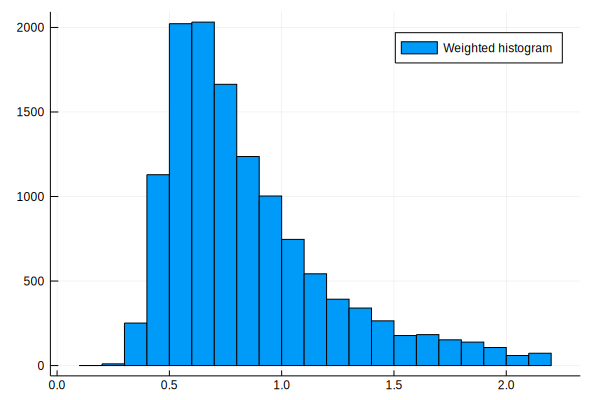

In [110]:
gr()
bins = collect(LinRange(0.1,2.2,22))
histogram(extra, label="Weighted histogram", bins=bins, weights=extra)
# png("histo_weighted")

In [28]:
tenth_arr = Vector{Vector{Bool}}(undef, 10)
for p = 1:1000:length(subm_path)-1000
    best_score = 100000000
    current_score = 100000000
    best_k = -1
    for k = 0:9
        tenth_arr[k+1] = [(i % 10) == k for i in 1:length(subm_path)-1][p:p+999]
        score, normal_dist, extra = calc_score(cities, subm_path[p:p+1000], tenth_arr[k+1])
        if score < best_score
            best_score = score
            best_k = k
        end
        if k == 0
            current_score = score
        end
    end
    if best_k != 0
        println("p: ", p)
        println("k: ", best_k)
        println("current: ", current_score)
        println("best: ", best_score)
    end
end

p: 28001
k: 4
current: 9028.919954181029
best: 9023.711819292696
p: 69001
k: 7
current: 6934.714132922448
best: 6934.598872750932
p: 82001
k: 3
current: 6804.371002046496
best: 6802.961320725436
p: 89001
k: 4
current: 5943.172828864562
best: 5940.356091584937
p: 121001
k: 1
current: 5857.162079013128
best: 5852.894304875104
p: 136001
k: 7
current: 9068.427486953356
best: 9067.238354855033
p: 137001
k: 3
current: 8500.48288583564
best: 8498.746461036688
p: 164001
k: 2
current: 6660.569064683388
best: 6660.457273294403
p: 166001
k: 5
current: 5993.724931361787
best: 5990.272885348433
p: 182001
k: 7
current: 8809.096519815741
best: 8807.556209620057
p: 187001
k: 3
current: 6934.675755902758
best: 6934.313531379395


In [8]:
counter = 1
ccolor = 1
tenth_full = [(i % 10) == 0 for i in 1:length(subm_path)]
tenth_and_noprime = cities.nprimes[subm_path] .* tenth_full

gr()
prime_idx = findall(cities_csv[:primes] .== true);
width = 5100
height = 3400

# plot(cities_csv[:X][subm_path[1:1000]], cities_csv[:Y][subm_path[1:1000]], markersize=1, 
#      seriestype=:path,size = (width, height), color = :RdYlBu, line_z = 1:100, label="", axis=false)
step_length = length(subm_path)
for k = 1:step_length:length(subm_path)
    plot(cities_csv[:X][prime_idx], cities_csv[:Y][prime_idx], markersize=4, markerstrokewidth=0, seriestype=:scatter,
        size = (width, height), label="", color=:orange, axis=false)
    red_tenth_x = Plots.Segments()
    red_tenth_y = Plots.Segments()             
    green_tenth_x = Plots.Segments()
    green_tenth_y = Plots.Segments()                
    for i=k+9:10:k+step_length
        if i+1 > length(subm_path)
            break
        end
        if tenth_and_noprime[i] == 1
           push!(red_tenth_x, cities_csv[:X][subm_path[i:i+1]])
           push!(red_tenth_y, cities_csv[:Y][subm_path[i:i+1]])
        else
           push!(green_tenth_x, cities_csv[:X][subm_path[i:i+1]])
           push!(green_tenth_y, cities_csv[:Y][subm_path[i:i+1]])               
        end                               
    end
    normal_x = Plots.Segments()
    normal_y = Plots.Segments()  
    for i=k:10:k+step_length
        if i+9 > length(subm_path)
            break
        end
       push!(normal_x, cities_csv[:X][subm_path[i:i+9]])
       push!(normal_y, cities_csv[:Y][subm_path[i:i+9]])                           
    end
    plot!(normal_x.pts, normal_y.pts, linewidth=1, 
          seriestype=:path,size = (width, height), color = :blue, label="", axis=false, 
          legend=false, colorbar=false)
    plot!(red_tenth_x.pts, red_tenth_y.pts, linewidth=4, 
          seriestype=:path,size = (width, height), color = :red, label="", axis=false, 
          legend=false, colorbar=false)
    plot!(green_tenth_x.pts, green_tenth_y.pts, linewidth=4, 
          seriestype=:path,size = (width, height), color = :green, label="", axis=false, 
          legend=false, colorbar=false)
    savefig("concorde.svg")
end

#=
frame(anim)
for i=1:each_length:1200 #length(subm_path)
    xlims_min = minimum(cities_csv[:X][subm_path[i:i+each_length]])
    xlims_max = maximum(cities_csv[:X][subm_path[i:i+each_length]])
    ylims_min = minimum(cities_csv[:Y][subm_path[i:i+each_length]])
    ylims_max = maximum(cities_csv[:Y][subm_path[i:i+each_length]])
    xlims_padding  = (600-(xlims_max-xlims_min))/2
    ylims_padding  = (337-(ylims_max-ylims_min))/2
    for k=i:i+each_length-1
       if k % 10 == 0 && !cities_csv[:primes][subm_path[i]]
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=4, 
                  seriestype=:path,size = (width, height), color = :red, label="", axis=false,
                  xlims = (xlims_min-xlims_padding,xlims_max+xlims_padding),
                  ylims = (ylims_min-ylims_padding,ylims_max+ylims_padding)
                )
        elseif k % 10 == 0
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=4, 
                  seriestype=:path, color = :green, label="", axis=false)
        else
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=1, 
                  seriestype=:path, color = :blue, label="", axis=false)
        end
    end
    frame(anim)
end
each_length = 10
for i=1201:each_length:2200 #length(subm_path)
    xlims_min = minimum(cities_csv[:X][subm_path[i:i+each_length]])
    xlims_max = maximum(cities_csv[:X][subm_path[i:i+each_length]])
    ylims_min = minimum(cities_csv[:Y][subm_path[i:i+each_length]])
    ylims_max = maximum(cities_csv[:Y][subm_path[i:i+each_length]])
    xlims_padding  = (600+5*(i-1201)-(xlims_max-xlims_min))/2
    ylims_padding  = (337+2.81*(i-1201)-(ylims_max-ylims_min))/2
    xlims_min = max(0, xlims_min-xlims_padding)     
    xlims_max = min(5100, xlims_max+xlims_padding)  
    ylims_min = max(0, ylims_min-ylims_padding)     
    ylims_max = min(3400, ylims_max+ylims_padding) 
    for k=i:i+each_length-1
       if k % 10 == 0 && !cities_csv[:primes][subm_path[i]]
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=4, 
                  seriestype=:path,size = (width, height), color = :red, label="", axis=false,
                  xlims = (xlims_min,xlims_max),
                  ylims = (ylims_min,ylims_max)
                )
        elseif k % 10 == 0
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=4, 
                  seriestype=:path, color = :green, label="", axis=false)
        else
            plot!(cities_csv[:X][subm_path[k:k+1]], cities_csv[:Y][subm_path[k:k+1]], linewidth=1, 
                  seriestype=:path, color = :blue, label="", axis=false)
        end
    end
    frame(anim)
    println("i: ", i)
end
each_length = 500             
for i=2201:each_length:length(subm_path)-each_length
    plot!(cities_csv[:X][subm_path[i:i+each_length]], cities_csv[:Y][subm_path[i:i+each_length]], linewidth=4, 
                  seriestype=:path,size = (width, height), color = :blue, label="", axis=false,
                  xlims = (0,5100),
                  ylims = (0,3400)
                )
    frame(anim)
    println("i: ", i)
end           
plot!(cities_csv[:X][subm_path[197701:length(subm_path)]], cities_csv[:Y][subm_path[197701:length(subm_path)]], linewidth=4, 
  seriestype=:path,size = (width, height), color = :red, label="", axis=false,
  xlims = (0,5100),
  ylims = (0,3400)
)
for i = 1:200
    frame(anim)
end
mp4(anim, "path_prime_20.mp4", fps = 20)
=#



In [44]:
gr()
x = rand(100)
y = rand(100)
plot(x,y, markersize=5, color=:red, seriestype=:scatter)
for i = 1:99
    if i % 10 == 0
        plot!(x[i:i+1], y[i:i+1], linewidth=4, 
              seriestype=:path, label="", axis=false, 
              legend=false, color=:blue, colorbar=false)
    else
        plot!(x[i:i+1], y[i:i+1], linewidth=1, 
              seriestype=:path, color=:blue, label="", axis=false, 
              legend=false, colorbar=false)
    end
end
png("mwe")


In [10]:
mp4(anim, "path_prime_7.mp4", fps = 7)

ErrorException: failed process: Process(`ffmpeg -v 0 -framerate 7 -loop 0 -i /tmp/tmpbuhS6F/%06d.png -pix_fmt yuv420p -y /home/ole/Kaggle/Santa_2018/path_prime_7.mp4`, ProcessExited(1)) [1]

In [11]:
clibraries()

5-element Array{Symbol,1}:
 :Plots      
 :cmocean    
 :misc       
 :colorcet   
 :colorbrewer